## Selecting band comparison segments

In [1]:
import numpy as np
from PIL import Image
from glob import glob
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mahotas

In [2]:
img_paths = sorted(glob('scenes_467/*'))
truth_paths = sorted(glob('truth_masks/*'))
slic_paths = sorted(glob('slics/*467.npy'))

In [3]:
# 0 - Fundo
# 1 - Desmatamento recente
# 2 - Floresta
# 3 - Ñ analisado

def is_mixed(segment):
    # flattening segment
    segment = segment.flatten()


    NFP = np.count_nonzero(segment == 2)
    NP = np.count_nonzero(segment) # desconsiderando o fundo (np.zeros)
    NNP = NP - NFP

    if NFP != 0 and NNP != 0:
        return True
    

    return False
    
def get_hor(segment):
    # flattening segment
    segment = segment.flatten()


    NFP = np.count_nonzero(segment == 2)
    NP = np.count_nonzero(segment) # desconsiderando o fundo
    NNP = NP - NFP

    HoR = max([NFP, NNP]) / NP

    return HoR

def get_major_class(segment):
    if np.argmax(np.bincount(segment.flatten())) == 2:
        return "forest"
    elif np.argmax(np.bincount(segment.flatten())) == 1:
        return "non forest"
    elif np.argmax(np.bincount(segment.flatten())) == 3:
        return "not analyzed"
    else:
        return np.argmax(np.bincount(segment.flatten()))

In [4]:
segments_image_df = []
segments_truth_df = []

In [5]:
global_segment_array = []
global_perfect_segments = []
for idx in range(len(img_paths)):
    total_segs = 0
    good_segs = 0
    bad_by_hor = 0
    bad_by_size = 0
    n_perfect_segs = 0
    image = np.asarray(Image.open(img_paths[idx]))
    truth = np.load(truth_paths[idx])
    slic = np.load(slic_paths[idx])

    props = regionprops(slic)
    segments_truth = []
    segments_image = []
    bad_segment_ids = []
    perfect_segs_truth = []

    assert slic.shape[:2] == truth.shape[:2]
    for i, prop in enumerate(props):
        total_segs += 1
        minr, minc, maxr, maxc = prop.bbox
        segment_truth = np.zeros((maxr - minr, maxc - minc))
        segment_image = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
        coords = np.array(prop.coords)
        for pixel in coords:
            segment_truth[pixel[0] - minr, pixel[1] - minc] = truth[pixel[0], pixel[1]]
            segment_image[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
        hor = get_hor(segment_truth)
        classification = get_major_class(np.uint8(segment_truth))
        if (segment_truth.shape[0] * segment_truth.shape[1] > 70) and (hor > 0.7) and (classification in ["forest", "non forest"]):
            segments_truth.append(np.uint8(segment_truth))
            segments_image.append(np.uint8(segment_image))
            segments_image_df.append({"Segment_label": prop.label, "HoR": hor, "Class": classification, "Region": f'x{idx + 1 :02d}'})
            segments_truth_df.append({"Segment_label": prop.label, "HoR": hor, "Class": classification, "Region": f'x{idx + 1 :02d}'})
            good_segs += 1
        if (hor<= 0.7):
            bad_by_hor += 1
            bad_segment_ids.append(prop.label)
        if (segment_truth.shape[0] * segment_truth.shape[1] <= 70 or classification == 0):
            bad_by_size += 1
            bad_segment_ids.append(prop.label)
        if (hor== 1):
            perfect_segs_truth.append(segment_truth)
            n_perfect_segs += 1
    global_segment_array.append(segments_truth)
    global_perfect_segments.append(perfect_segs_truth)

    # flagging bad segments
    bad_segment_ids = set(bad_segment_ids) # removes duplicates
    for bad_id in bad_segment_ids:
        slic = np.where(slic == bad_id, -1, slic)
    
    np.save(slic_paths[idx], slic)

    print(f'x{idx + 1 :02d}: total_segs = {total_segs} | good_segs = {good_segs} | bad_segs = {total_segs - good_segs} | bad_segs because of HoR = {bad_by_hor} | bad_segs because of size = {bad_by_size} | perfect_segs = {n_perfect_segs}')

    

x01: total_segs = 2254 | good_segs = 1692 | bad_segs = 562 | bad_segs because of HoR = 0 | bad_segs because of size = 0 | perfect_segs = 1819
x02: total_segs = 2395 | good_segs = 1316 | bad_segs = 1079 | bad_segs because of HoR = 0 | bad_segs because of size = 0 | perfect_segs = 1599
x03: total_segs = 1908 | good_segs = 1192 | bad_segs = 716 | bad_segs because of HoR = 0 | bad_segs because of size = 0 | perfect_segs = 1148
x04: total_segs = 1889 | good_segs = 484 | bad_segs = 1405 | bad_segs because of HoR = 0 | bad_segs because of size = 0 | perfect_segs = 968
x05: total_segs = 1044 | good_segs = 648 | bad_segs = 396 | bad_segs because of HoR = 0 | bad_segs because of size = 0 | perfect_segs = 515
x06: total_segs = 2366 | good_segs = 1121 | bad_segs = 1245 | bad_segs because of HoR = 0 | bad_segs because of size = 0 | perfect_segs = 1316
x07: total_segs = 2485 | good_segs = 2025 | bad_segs = 460 | bad_segs because of HoR = 0 | bad_segs because of size = 0 | perfect_segs = 1660
x08: to

In [6]:
segments_image_df = pd.DataFrame.from_records(segments_image_df)
segments_truth_df = pd.DataFrame.from_records(segments_truth_df)

In [7]:
segments_image_df.head()

,Segment_label,HoR,Class,Region
0,1,1.0,forest,x01
1,2,1.0,forest,x01
2,4,1.0,forest,x01
3,5,1.0,forest,x01
4,6,1.0,forest,x01


In [8]:
for idx, segment_list in enumerate(global_segment_array):
    forest_count = 0
    non_forest_count = 0
    for segment in segment_list:
        if (np.argmax(np.bincount(segment.flatten())) == 2):
            forest_count += 1
        elif (np.argmax(np.bincount(segment.flatten())) == 1):
            non_forest_count += 1
    
    print(f'across x{idx + 1 :02d}: forest = {forest_count} | non forest = {non_forest_count}')



across x01: forest = 1585 | non forest = 107
across x02: forest = 1182 | non forest = 134
across x03: forest = 1167 | non forest = 25
across x04: forest = 475 | non forest = 9
across x05: forest = 612 | non forest = 36
across x06: forest = 1104 | non forest = 17
across x07: forest = 2016 | non forest = 9
across x08: forest = 928 | non forest = 36
across x09: forest = 1582 | non forest = 19
across x10: forest = 820 | non forest = 35


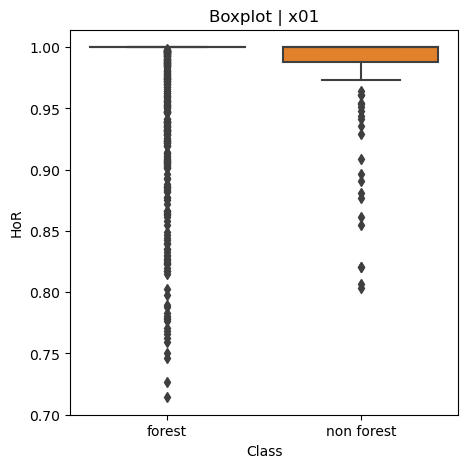

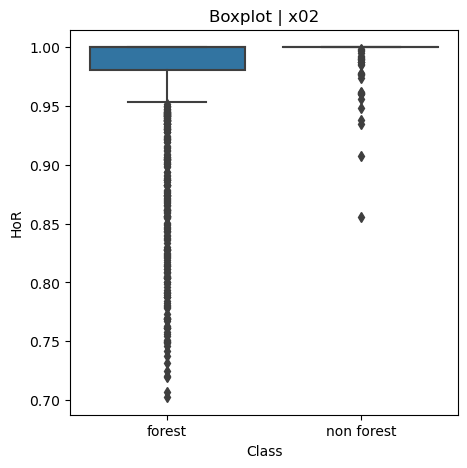

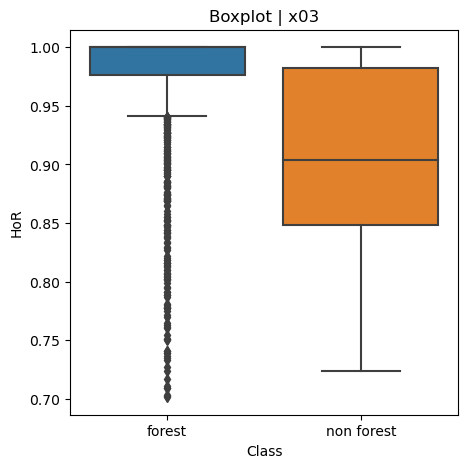

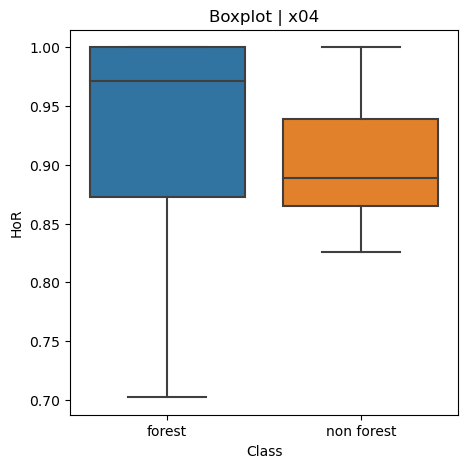

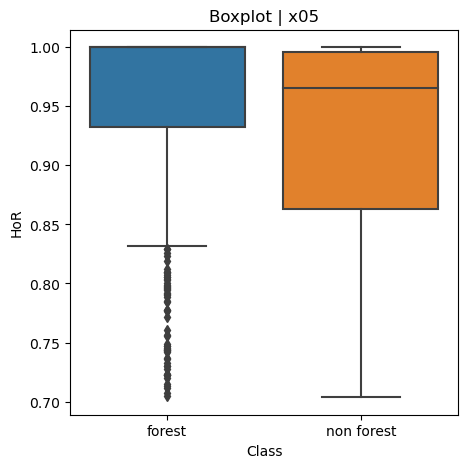

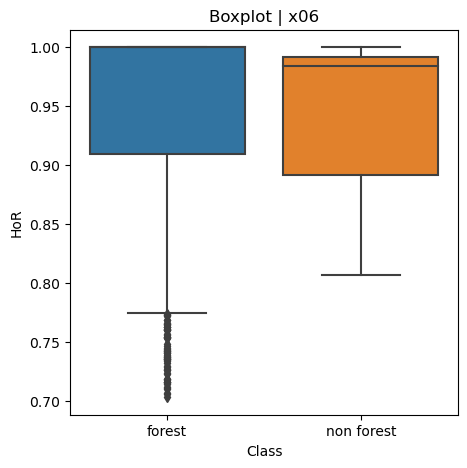

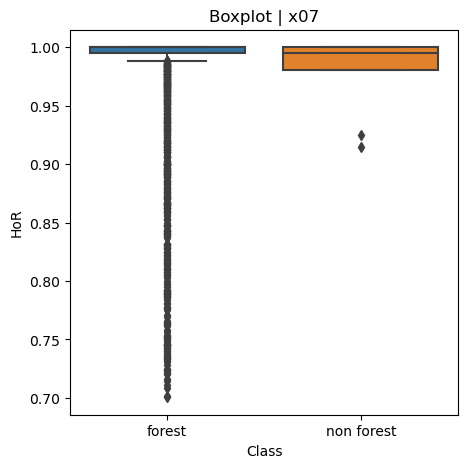

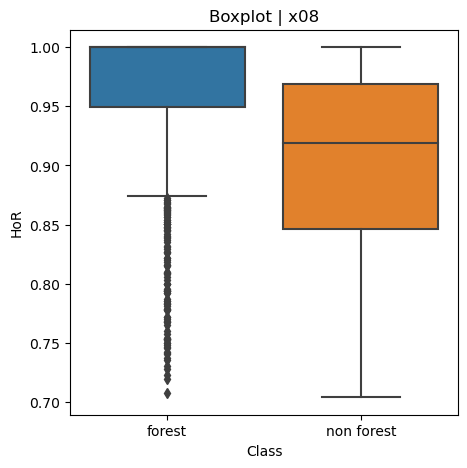

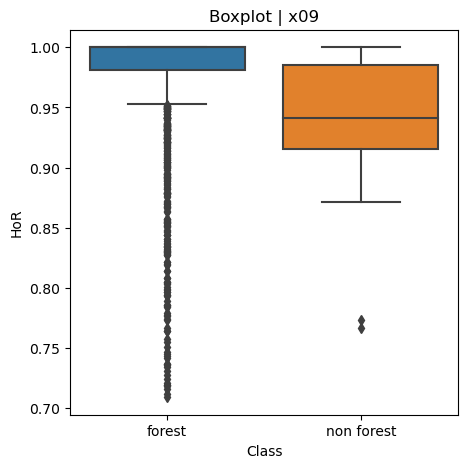

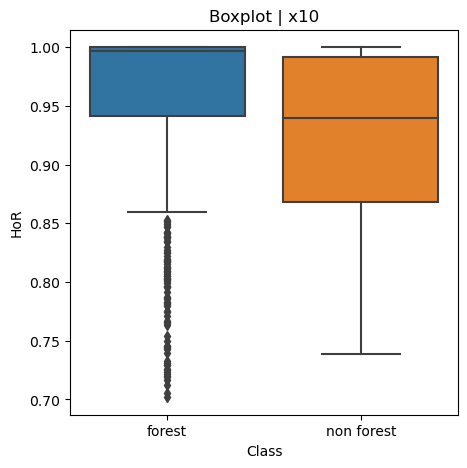

In [9]:
for i in range(1, 11):
    fig = plt.figure(figsize=(5, 5))
    data = segments_truth_df[segments_truth_df['Region'] == f'x{i:02d}']
    data = data.reset_index(drop=True)
#     #Create a figure with two subplots
#     fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#     # Plot the displot on the first subplot
#     sns.histplot(data=data, x='HoR', hue='Class', kde=True, ax=axes[0])
#     axes[0].set_title(f'Distribution | x{i :02d}')

#     # Plot the boxplot on the second subplot
#     sns.boxplot(data=data, x='Class', y='HoR', ax=axes[1])
#     axes[1].set_title(f'Boxplot | x{i :02d}')

#     # Adjust the spacing between subplots
#     plt.tight_layout()

#     # Display the plot
#     plt.show()

    ax = sns.boxplot(data, x='Class', y='HoR')
    ax.set_title(f'Boxplot | x{i :02d}')


Text(0.5, 1.0, 'Boxplot | all regions')

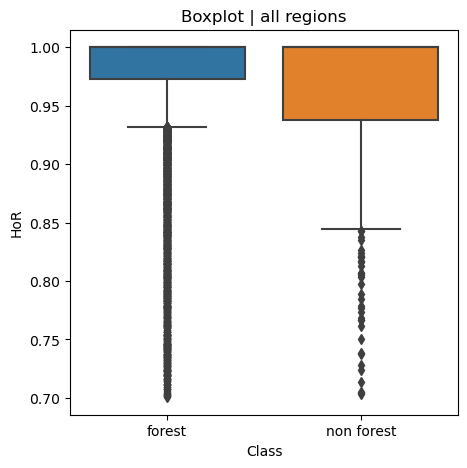

In [10]:
fig = plt.figure(figsize=(5, 5))
data = segments_truth_df
data = data.reset_index(drop=True)
ax = sns.boxplot(data, x='Class', y='HoR')
ax.set_title(f'Boxplot | all regions')


### Pixel count

In [10]:
for idx, segment_list in enumerate(global_segment_array):
    forest_pix_count = 0
    non_forest_pix_count = 0
    for segment in segment_list:
        for pixel in segment.flatten():
            if pixel == 2:
                forest_pix_count += 1
            elif pixel == 1:
                non_forest_pix_count += 1
    
    print(f'across x{idx + 1 :02d}: forest pix = {forest_pix_count :6d} | non forest pix = {non_forest_pix_count :6d} | forest pix / non-forest pix = {forest_pix_count / non_forest_pix_count :.3f}')

across x01: forest pix = 467773 | non forest pix =  34616 | forest pix / non-forest pix = 13.513
across x02: forest pix = 386323 | non forest pix =  46762 | forest pix / non-forest pix = 8.261
across x03: forest pix = 324447 | non forest pix =   6103 | forest pix / non-forest pix = 53.162
across x04: forest pix =  83117 | non forest pix =   1615 | forest pix / non-forest pix = 51.466
across x05: forest pix = 202728 | non forest pix =  11131 | forest pix / non-forest pix = 18.213
across x06: forest pix = 213165 | non forest pix =   3539 | forest pix / non-forest pix = 60.233
across x07: forest pix = 894724 | non forest pix =   4989 | forest pix / non-forest pix = 179.339
across x08: forest pix = 240911 | non forest pix =  10387 | forest pix / non-forest pix = 23.194
across x09: forest pix = 480582 | non forest pix =   6008 | forest pix / non-forest pix = 79.990
across x10: forest pix = 291749 | non forest pix =  12201 | forest pix / non-forest pix = 23.912


### Exporting segments from all regions

In [17]:
info = []
for i in range(1, 11):
    region_segments = segments_image_df[segments_image_df['Region'] == f'x{i :02d}']
    counts = region_segments['Class'].value_counts()
    # export_num = min([counts['forest'], counts['non forest'], 100])
    
    # selecting segments
    selected_segments = region_segments.sort_values(by='HoR', ascending=False)
    # selected_segments = selected_segments.groupby('Class')

    # exporting segments
    print(selected_segments.shape)
    # getting labels
    # forest_labels = (selected_segments[selected_segments['Class'] == 'forest'])['Segment_label'].values
    # non_forest_labels = selected_segments[selected_segments['Class'] == 'non forest']['Segment_label'].values

(1692, 4)
(1316, 4)
(1192, 4)
(484, 4)
(648, 4)
(1121, 4)
(2025, 4)
(964, 4)
(1601, 4)
(855, 4)


In [18]:
info = []
for i in range(1, 11):
    region_segments = segments_image_df[segments_image_df['Region'] == f'x{i :02d}']
    counts = region_segments['Class'].value_counts()
    # export_num = min([counts['forest'], counts['non forest'], 100])
    
    # selecting segments
    selected_segments = region_segments.sort_values(by='HoR', ascending=False)
    # selected_segments = selected_segments.groupby('Class')

    # exporting segments

    # getting labels
    forest_labels = (selected_segments[selected_segments['Class'] == 'forest'])['Segment_label'].values
    non_forest_labels = selected_segments[selected_segments['Class'] == 'non forest']['Segment_label'].values

    # loading scenes
    image = np.load(f'scenes_allbands/allbands_x{i :02d}.npy')
    slic = np.load(f'slics/slic_x{i :02d}.npy')
    props = regionprops(slic)

    
    # saving segments
    saved_forest = 0
    saved_nonforest = 0
    for prop in props:
        if prop.label in forest_labels:
            minr, minc, maxr, maxc = prop.bbox
            image_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
            coords = np.array(prop.coords)
            for pixel in coords:
                image_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
            
            img = np.uint8(image_segment)
            har_bands = []

            for band in range(img.shape[-1]):
                har_forest = mahotas.features.haralick(img[:, :, band])
                har_bands.append(har_forest)
        
            img = np.stack(har_bands)

            np.save(f'data/dataset_v3-467/forest/forest_x{i :02d}_{prop.label}.npy', img)
            saved_forest += 1

        if prop.label in non_forest_labels:
            minr, minc, maxr, maxc = prop.bbox
            image_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
            coords = np.array(prop.coords)
            for pixel in coords:
                image_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
            
            img = np.uint8(image_segment)
            har_bands = []
            
            for band in range(img.shape[-1]):
                har_forest = mahotas.features.haralick(img[:, :, band])
                har_bands.append(har_forest)
        
            img = np.stack(har_bands)

            np.save(f'data/dataset_v3-467/non_forest/nonforest_x{i :02d}_{prop.label}.png', img)
            saved_nonforest += 1
    info.append(dict(region=f'x{i :02d}', forest=saved_forest, nonforest=saved_nonforest, total=(saved_forest + saved_nonforest)))
        
    # assert (saved_forest == export_num) and (saved_nonforest == export_num)

In [19]:
log = pd.DataFrame.from_records(info)
log

,region,forest,nonforest,total
0,x01,1585,107,1692
1,x02,1182,134,1316
2,x03,1167,25,1192
3,x04,475,9,484
4,x05,612,36,648
5,x06,1104,17,1121
6,x07,2016,9,2025
7,x08,928,36,964
8,x09,1582,19,1601
9,x10,820,35,855


In [20]:
log.sum()

region       x01x02x03x04x05x06x07x08x09x10
forest                                11471
nonforest                               427
total                                 11898
dtype: object